In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

In [6]:
df = pd.read_csv('../data/weblogs1.csv')

In [7]:
df = df.drop(['HTTP_RESPONSE_2XX', 'GET_METHOD', 'ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(26940, 18) (6736, 18) (26940,) (6736,)


### K-NearestNeighborsClassifier

##### Met scaler testen

In [26]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn_scaled = {
    'n_neighbors': np.arange(1, 50, 5),
    'weights': ['uniform', 'distance'], 
    'metric': ['euclidean', 'manhattan'], 
    'algorithm': ['auto', 'ball_tree', 'kd_tree']
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(param_grid=param_grid_knn_scaled, estimator=KNeighborsClassifier(), cv=5, n_jobs=-1, verbose=2))
])

In [27]:
pipeline.fit(X_train, y_train)

y_pred_knn_scaled = pipeline.predict(X_test)

print(classification_report(y_test, y_pred_knn_scaled))
print(confusion_matrix(y_test, y_pred_knn_scaled))
print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_knn_scaled)) * 100)) + "%")

Fitting 5 folds for each of 120 candidates, totalling 600 fits
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      5393
           1       0.95      0.92      0.93      1343

    accuracy                           0.97      6736
   macro avg       0.96      0.95      0.96      6736
weighted avg       0.97      0.97      0.97      6736

[[5325   68]
 [ 114 1229]]

Accuracy: 97.30%


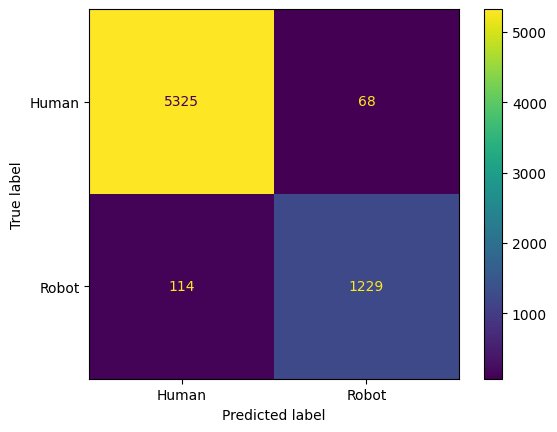

In [28]:
cmDiplay = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_knn_scaled), display_labels=['Human', 'Robot'])
cmDiplay.plot()

In [29]:
pipeline.named_steps['grid_search'].best_params_

{'algorithm': 'ball_tree',
 'metric': 'manhattan',
 'n_neighbors': 16,
 'weights': 'distance'}

##### Zonder scaler

In [30]:
grid_search_no_scale = GridSearchCV(param_grid=param_grid_knn_scaled, estimator=KNeighborsClassifier(), cv=5, n_jobs=-1, verbose=2)

In [31]:
grid_search_no_scale.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree'],
                         'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46]),
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [32]:
y_pred_knn_no_scale = grid_search_no_scale.predict(X_test)

print(classification_report(y_test, y_pred_knn_no_scale))
print(confusion_matrix(y_test, y_pred_knn_no_scale))
print("\nAccuracy: {:.2f}".format(((accuracy_score(y_test, y_pred_knn_no_scale)) * 100)) + "%")

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5393
           1       0.84      0.76      0.80      1343

    accuracy                           0.92      6736
   macro avg       0.89      0.86      0.88      6736
weighted avg       0.92      0.92      0.92      6736

[[5203  190]
 [ 322 1021]]

Accuracy: 92.40%


Scaling is nodig voor betere resultaten

In [33]:
filename = '../main_models/kneighbors_classifier1.sav'

knn = pipeline.named_steps['grid_search'].best_estimator_

pickle.dump(knn, open(filename, 'wb'))

### Logistic Regression

##### Met scaling

In [40]:
from sklearn.linear_model import LogisticRegression

In [41]:
param_grid = {
    'C': [0.1, 1, 10, 20, 30, 100],
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1))
])

In [42]:
pipeline.fit(X_train, y_train)

y_pred_lgr = pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lgr))
print(confusion_matrix(y_test, y_pred_lgr))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5393
           1       0.82      0.92      0.87      1343

    accuracy                           0.94      6736
   macro avg       0.90      0.93      0.91      6736
weighted avg       0.95      0.94      0.94      6736

[[5119  274]
 [ 109 1234]]


c:\Users\buyse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
pipeline.named_steps['grid_search'].best_params_

{'C': 30}

In [34]:
filename = '../main_models/logistic_regression1.sav'

lgr = pipeline.named_steps['grid_search'].best_estimator_

pickle.dump(lgr, open(filename, 'wb'))

##### Zonder scaling

In [47]:
gs_no_scale = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, n_jobs=-1)

gs_no_scale.fit(X_train, y_train)

y_pred_lgr_no_scale = gs_no_scale.predict(X_test)

print(classification_report(y_test, y_pred_lgr_no_scale))

print(confusion_matrix(y_test, y_pred_lgr_no_scale))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      5393
           1       0.87      0.01      0.02      1343

    accuracy                           0.80      6736
   macro avg       0.83      0.50      0.45      6736
weighted avg       0.81      0.80      0.72      6736

[[5391    2]
 [1330   13]]


aantal mensen dat als robot wordt herkend is zeer klein --> dat willen we

In [48]:
filename2 = "../main_models/logistic_regression_no_scale1.sav"

lgr_no_scale = gs_no_scale.best_estimator_

pickle.dump(lgr_no_scale, open(filename2, 'wb'))

### Linear SVC

##### Met scaling

In [56]:
from sklearn.svm import LinearSVC

In [59]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 2000, 3000, 4000, 5000]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('grid_search', GridSearchCV(LinearSVC(random_state=42), param_grid, n_jobs=-1, cv=5))
])

In [60]:
pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96      5393
           1       0.81      0.92      0.86      1343

    accuracy                           0.94      6736
   macro avg       0.90      0.93      0.91      6736
weighted avg       0.95      0.94      0.94      6736

[[5108  285]
 [ 105 1238]]


c:\Users\buyse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [61]:
pipeline.named_steps['grid_search'].best_params_

{'C': 1, 'max_iter': 1000}

In [64]:
filename = '../main_models/linear_svc1.sav'

lsvc = pipeline.named_steps['grid_search'].best_estimator_

pickle.dump(lsvc, open(filename, 'wb'))

##### Zonder scaling

In [62]:
gs_no_scale = GridSearchCV(LinearSVC(random_state=42), param_grid, n_jobs=-1, cv=5)

gs_no_scale.fit(X_train, y_train)

y_pred_no_scale = gs_no_scale.predict(X_test)

print(classification_report(y_test, y_pred_no_scale))

print(confusion_matrix(y_test, y_pred_no_scale))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      5393
           1       0.73      0.48      0.57      1343

    accuracy                           0.86      6736
   macro avg       0.80      0.72      0.75      6736
weighted avg       0.85      0.86      0.85      6736

[[5152  241]
 [ 705  638]]


c:\Users\buyse\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Alweer minder mensen die als robot worden gezien, maar wel grotere recall

In [63]:
filename2 = "../main_models/linear_svc_no_scale1.sav"

lsvc_no_scale = gs_no_scale.best_estimator_

pickle.dump(lsvc_no_scale, open(filename2, 'wb'))